**Theoretical Questions:**

*1) Differnce between traditional convolutional networks and Deformable convolutional networks in view of grid sampling:*

In traditional CNN, the grid sampling is fixed such that the each output in the feature map belongs to an specific receptive field on the input feature map, and this receptive field is fixed. On the other hand, in deformable convolutional networks, the grid sampling is deformable, so that the receptive field might change through the learning stage. This flexiblity enables positively effects the networks' capability.

*2) how are deformable convolutions robust against Geometric transformations.*

These networks allow their kernels to adapt their receptive field during the learning stage. This is so helpful in handling the effect of Geometric transformations such as object deformation, rotation and spacial displacements. This capability is due to an offset that can be learned during the training stage.


*3) Why does traditional convolutional network face problem when dealing with objects with spacial transformations.*

As we know, the kernels' size and their receptive field are fixed in traditional convolutional networks. Moreover, spacial transormations lead to change in the output of kernels which means that the they cannot deal with such transformations.

*4) how are offsets trained in deformable convolutional networks?*

In defromable CNN, there is a module called offset prediction network. This network is responsible for predicting the best parameter values for the offsets. It takes the input feature map and returns the predicted offsets for each spatial location within the receptive field of the deformable convolutional layers.Then, the predicted offsets are used to generate a sampling grid for each location within the receptive field. The grid represents the sampling locations within the input feature map that will be used to compute the convolutional output. The weights of the filters are multiplied by the sample input values ​​to calculate the output feature map. Finally, the entire network, including the offset prediction network, is trained using backpropagation.


To write the python code of this question, I have used MNIST dataset. It is because I had not access to the labeled version of cocodataset.

Stage 1:
traditional convolutional network:

Firsly, we import required libraries and packages:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.ops as ops
from tqdm import tqdm
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torchvision.datasets as dset
!wget http://images.cocodataset.org/zips/train2017.zip

--2023-12-18 11:55:22--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.224.65, 54.231.136.145, 3.5.8.13, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.224.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  55.4MB/s    in 3m 41s  

2023-12-18 11:59:03 (83.3 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



Here, we load the dataset:

In [ ]:
%%capture
!unzip train2017.zip

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In this part, we write two class for traditional and deformable convolution network:

In [ ]:
class CNN_traditional(nn.Module):
    def __init__(self):
        super(CNN_traditional, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.classifier = nn.Linear(7*7*32, 10)

    def forward(self, x):
        out = self.feature_extractor(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out



class CNN_deformable(nn.Module):
    def __init__(self):
        super(CNN_deformable, self).__init__()
        self.offset_conv1 = nn.Conv2d(1, 72,kernel_size=6,stride=1,padding=2)
        self.offset_conv2 = nn.Conv2d(16,72,kernel_size=6,stride=1,padding=2)
        self.postConv = nn.Sequential(nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2))
        self.classifier = nn.Linear(2592, 10)
        self.regular_conv = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=6,stride=1,padding=1)


    def forward(self, x):
        offset = self.offset_conv1(x)
        out = ops.deform_conv2d(x, offset, weight=self.regular_conv.weight, stride=1, padding=2)
        out = self.postConv(out)
        offset = self.offset_conv2(out)
        out = ops.deform_conv2d(out, offset,weight=self.offset_conv2.weight, stride=1, padding=2)
        out = self.postConv(out)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

In this part, we initialize the model, and the optimizer and loss function.

In [ ]:
model_trad = CNN_traditional().to(device)
model_deform = CNN_deformable().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_trad = optim.SGD(model_trad.parameters(), lr=0.001)
optimizer_deform = optim.SGD(model_deform.parameters(), lr=0.001)

In this stage, we train both models through two epochs:

In [ ]:
total_step = len(train_loader)
num_epochs = 3
Loss_trad = []
Acc_trad = []
start = time.time()
for epoch in range(num_epochs):
  acc = 0.0
  running_loss = 0.0
  with tqdm(train_loader, unit="batch") as tepoch:
    for images, labels in tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs_trad = model_trad(images)

        loss_trad = criterion(outputs_trad, labels)

        # Backward and optimize
        optimizer_trad.zero_grad()

        loss_trad.backward()

        optimizer_trad.step()

        predictions_trad = outputs_trad.argmax(dim=1, keepdim=True).squeeze()

        correct_trad = (predictions_trad == labels).sum().item()
        accuracy_trad = correct_trad / len(labels)
        acc += accuracy_trad
        running_loss += loss_trad.item()
        tepoch.set_postfix(loss=loss_trad.item(), accuracy=100. * accuracy_trad)
  Loss_trad.append(running_loss/len(train_loader))
  Acc_trad.append(100*acc/len(train_loader))

end = time.time()
training_duration_trad = end - start



Epoch 2: 100%|██████████| 938/938 [01:00<00:00, 15.42batch/s, accuracy=93.8, loss=0.284]


In [ ]:
total_step = len(train_loader)
num_epochs = 3
Loss_deform = []
Acc_deform = []
start = time.time()

for epoch in range(num_epochs):
  acc = 0.0
  running_loss = 0.0
  with tqdm(train_loader, unit="batch") as tepoch:
    for images, labels in tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs_deform = model_deform(images)

        loss_deform = criterion(outputs_deform, labels)


        optimizer_deform.zero_grad()
        loss_deform.backward()
        optimizer_deform.step()

        predictions_deform = outputs_deform.argmax(dim=1, keepdim=True).squeeze()

        correct_deform = (predictions_deform == labels).sum().item()
        accuracy_deform = correct_deform / len(labels)
        acc += accuracy_deform
        running_loss += loss_deform.item()
        tepoch.set_postfix(loss=loss_deform.item(), accuracy=100. * accuracy_deform)
    Loss_deform.append(running_loss/len(train_loader))
    Acc_deform.append(100*acc/len(train_loader))
end = time.time()
training_duration_deform = end - start

Here, we test the trained models:

In [56]:
model_trad.eval()  # Evaluation mode (batch normalization uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct_deform, correct_trad, total = 0, 0, 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs_trad = model_trad(images)
        outputs_deform = model_deform(images)
        _, predicted_trad = torch.max(outputs_trad.data, 1)
        _, predicted_deform = torch.max(outputs_deform.data, 1)
        total += labels.size(0)
        correct_trad += (predicted_trad == labels).sum().item()/len(labels)
        correct_deform += (predicted_deform == labels).sum().item()/len(labels)

correct_trad = 100*correct_trad/len(test_loader)
correct_deform = 100*correct_deform/len(test_loader)

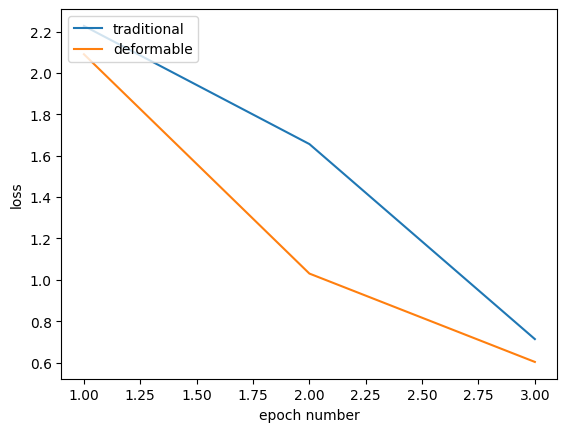

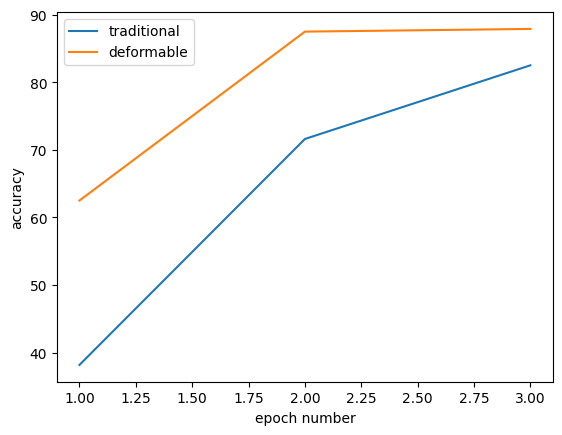

test accuracy of traditional cnn is: 86.9327229299363
test accuracy of deformable cnn is: 89.46058917197452
running time for training traditional cnn is: 178.27051496505737
running time for training traditional cnn is: 6067.142855644226


In [59]:
import matplotlib.pyplot as plt
epochs = [1,2,3]
plt.plot(epochs, Loss_trad, label='traditional')
plt.plot(epochs, Loss_deform,label='deformable')
plt.legend(loc="upper left")
plt.xlabel('epoch number')
plt.ylabel('loss')
plt.show()

plt.plot(epochs, Acc_trad, label='traditional')
plt.plot(epochs, Acc_deform,label='deformable')
plt.legend(loc="upper left")
plt.xlabel('epoch number')
plt.ylabel('accuracy')
plt.show()

print('test accuracy of traditional cnn is:', correct_trad)
print('test accuracy of deformable cnn is:', correct_deform)

print('running time for training traditional cnn is:',training_duration_trad)
print('running time for training traditional cnn is:',training_duration_deform)

***As expected, the training time of the deformable cnn is hugely greater that that of traditional networks. Instead, the test accuracy of deformable network is larger than that of traditional network.***